## Miniproject 2: MovieLens Visualization



### Download data

In [13]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y))

In [16]:
M = max(data["User ID"]) # number of users
N = max(data["Movie ID"]) # number of movies

K = 20

reg = 0.1
eta = 0.03 # learning rate

U,V,err = train_model(M, N, K, eta, reg, train.to_numpy())
test_err = get_err(U, V, test.to_numpy())
print("Test error " + str(test_err))

Epoch 1, E_in (regularized MSE): 0.5101626828686007
Epoch 2, E_in (regularized MSE): 0.43004229497508684
Epoch 3, E_in (regularized MSE): 0.4072996898883374
Epoch 4, E_in (regularized MSE): 0.3876579007460575
Epoch 5, E_in (regularized MSE): 0.37482743161194204
Epoch 6, E_in (regularized MSE): 0.3627313018921398
Epoch 7, E_in (regularized MSE): 0.35555571125163954
Epoch 8, E_in (regularized MSE): 0.34925696639689463
Epoch 9, E_in (regularized MSE): 0.3420824093951397
Epoch 10, E_in (regularized MSE): 0.3373088885825692
Epoch 11, E_in (regularized MSE): 0.3283959048734079
Epoch 12, E_in (regularized MSE): 0.323474046265063
Epoch 13, E_in (regularized MSE): 0.3205198575857479
Epoch 14, E_in (regularized MSE): 0.3183879048287259
Epoch 15, E_in (regularized MSE): 0.31254353100706933
Epoch 16, E_in (regularized MSE): 0.31079882348776994
Epoch 17, E_in (regularized MSE): 0.309216569539649
Epoch 18, E_in (regularized MSE): 0.304910512840067
Epoch 19, E_in (regularized MSE): 0.3054721750813570

In [5]:
A, _, _ = np.linalg.svd(V)
A1 = (A[:,:2]).T
print(A1.shape)
print(U.shape)
print(V.shape)
Ut = np.matmul(A1, U.T)
Vt = np.matmul(A1, V)
print(Vt.shape)

(2, 20)
(943, 20)
(20, 1682)
(2, 1682)


In [6]:
most_popular = data['Movie ID'].value_counts()[:10].index.to_numpy()
most_popular_labels = movies.loc[movies['Movie ID'].isin(most_popular)]["Movie Title"]
print(most_popular)
print(most_popular_labels)
most_popular_labels = most_popular_labels[most_popular - 1].to_numpy()
most_popular_labels

[ 50 258 100 181 294 286 288   1 300 121]
0                   Toy Story (1995)
49                  Star Wars (1977)
99                      Fargo (1996)
120    Independence Day (ID4) (1996)
180        Return of the Jedi (1983)
257                   Contact (1997)
285      English Patient, The (1996)
287                    Scream (1996)
293                 Liar Liar (1997)
299             Air Force One (1997)
Name: Movie Title, dtype: object


array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [7]:
condensed = data.groupby('Movie ID', as_index=False, sort=False)['Rating'].mean()
best = np.asarray(condensed.nlargest(10, 'Rating')["Movie ID"].tolist())
best_labels = movies.loc[movies['Movie ID'].isin(best)]["Movie Title"]
print(best)
best_labels = best_labels[best - 1].to_numpy()
print(best_labels)

[1189 1500  814 1536 1293 1599 1653 1467 1122 1201]
['Prefontaine (1997)' 'Santa with Muscles (1996)'
 'Great Day in Harlem, A (1994)' 'Aiqing wansui (1994)' 'Star Kid (1997)'
 "Someone Else's America (1995)"
 'Entertaining Angels: The Dorothy Day Story (1996)'
 'Saint of Fort Washington, The (1993)' 'They Made Me a Criminal (1939)'
 'Marlene Dietrich: Shadow and Light (1996) ']


          x         y                           name
0  2.206503 -0.032145               Star Wars (1977)
1  1.973749 -0.131917                 Contact (1997)
2  2.278671  0.616135                   Fargo (1996)
3  2.187789 -0.346259      Return of the Jedi (1983)
4  1.716310 -0.786720               Liar Liar (1997)
5  1.920257  0.248289    English Patient, The (1996)
6  1.802797 -0.328568                  Scream (1996)
7  2.186538 -0.276554               Toy Story (1995)
8  1.928453 -0.800210           Air Force One (1997)
9  1.765058 -0.848865  Independence Day (ID4) (1996)


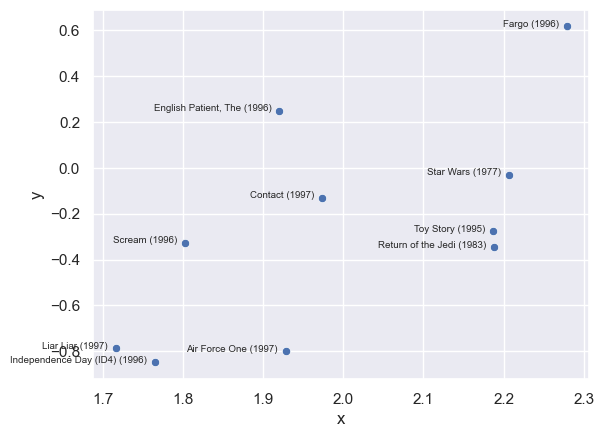

In [8]:
most_popular_data = pd.DataFrame(Vt[:,most_popular-1].T, columns=['x', 'y'])
most_popular_data.insert(2, 'name', most_popular_labels, True)
print(most_popular_data)
sns.scatterplot(data=most_popular_data, x='x', y='y')

for i in range(len(most_popular_data)):
    plt.text(most_popular_data['x'][i] - 0.01, most_popular_data['y'][i], \
             most_popular_data['name'][i], fontsize=7, ha='right')
    
plt.savefig('figs/task2-popular')

          x         y                                               name
0  2.166891 -0.227375                                 Prefontaine (1997)
1  2.117056  0.013560                          Santa with Muscles (1996)
2  1.467117  0.191195                      Great Day in Harlem, A (1994)
3  1.500267  0.931971                               Aiqing wansui (1994)
4  1.949365  0.541188                                    Star Kid (1997)
5  1.632940  0.487462                      Someone Else's America (1995)
6  1.441447  0.340556  Entertaining Angels: The Dorothy Day Story (1996)
7  2.223283  0.303966               Saint of Fort Washington, The (1993)
8  1.937730  0.115229                     They Made Me a Criminal (1939)
9  1.715992  0.917866         Marlene Dietrich: Shadow and Light (1996) 


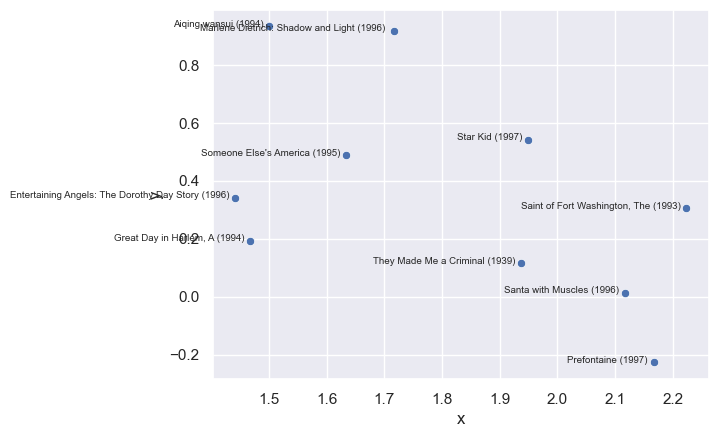

In [9]:
best_data = pd.DataFrame(Vt[:,best-1].T, columns=['x', 'y'])
best_data.insert(2, 'name', best_labels, True)
print(best_data)
sns.scatterplot(data=best_data, x='x', y='y')

for i in range(len(best_data)):
    plt.text(best_data['x'][i] - 0.01, best_data['y'][i], \
             best_data['name'][i], fontsize=7, ha='right')
plt.savefig('figs/task2-best')

          x         y                        name
0  1.911408 -0.542039        Jurassic Park (1993)
1  2.069665 -0.493100  Sound of Music, The (1965)
2  1.812438 -0.801803              Top Gun (1986)
3  1.529338 -0.333237       Batman Returns (1992)
4  2.115264 -0.330895         Men in Black (1997)
5  2.238161 -0.079192    Good Will Hunting (1997)
6  1.802797 -0.328568               Scream (1996)
7  1.680122 -0.274975               Batman (1989)
8  2.424151 -0.006177     Schindler's List (1993)
9  1.995031  0.599832        Koyaanisqatsi (1983)


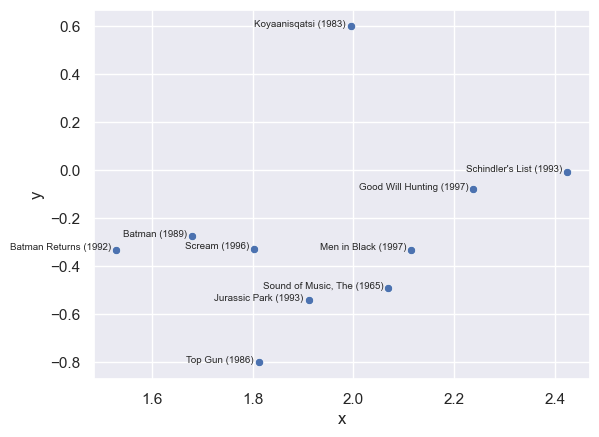

In [12]:
movie_id1 = np.array([82, 143, 161, 231, 257, 272, 288, 403, 318, 1065])
labels1 = movies.loc[movies['Movie ID'].isin(movie_id1)]["Movie Title"]
labels1 = labels1[movie_id1 - 1].to_numpy()

selected_data = pd.DataFrame(Vt[:,movie_id1-1].T, columns=['x', 'y'])
selected_data.insert(2, 'name', labels1, True)
print(selected_data)
sns.scatterplot(data=selected_data, x='x', y='y')

for i in range(len(selected_data)):
    plt.text(selected_data['x'][i] - 0.01, selected_data['y'][i], \
             selected_data['name'][i], fontsize=7, ha='right')
    
# In the figure below, left is fictional vs. right is historical
# Bottom is light-hearted, top is profound/deep/requires interpretation

In [11]:
movies

,Movie ID,Movie Title,Unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
